In [12]:
import numpy as np
import torch
import torch.nn as nn
import scipy
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [13]:
k0, kd, k1, j1, km1, jm1, j2, km3, jm3, k2 = (0.1, 0.05, 0.6, 0.1, 0.2, 0.1, 0.1, 7.05, 2.0, 0.4)

initial_values = (0.248, 0.0973, 0.0027)

In [14]:
class CellApoptosisSystem:
    def __init__(self, initial_X, k0, kd, k1, j1, km1, jm1, j2, km3, jm3, k2):
        self.initial_X, self.k0, self.kd, self.k1, self.j1, self.km1, self.jm1, self.j2, self.km3, self.jm3, self.k2 = initial_X,k0,kd,k1,j1,km1,jm1,j2,km3,jm3,k2

    def model(X, _, k0, kd, k1, j1, km1, jm1, j2, km3, jm3, k2):
        x, y, z = X
        v0 = k0
        v1 = k1 * z * (j1 + y)
        vm1 = km1 * y / (jm1 + y)
        v2 = k2 * y * x / (j2 + x)
        vm3 = km3 * x * y / (jm3 + y)

        dxdt = v0 - v2 -kd * x
        dydt = v1 - vm1 - vm3
        dzdt = -dydt

        return np.array([dxdt, dydt, dzdt])

    def solve(self, t):
        res = odeint(CellApoptosisSystem.model, self.initial_X, t, args=(self.k0, self.kd, self.k1, self.j1, self.km1, self.jm1, self.j2, self.km3, self.jm3, self.k2))
        return res


In [15]:
CA = CellApoptosisSystem(initial_values, k0, kd, k1, j1, km1, jm1, j2, km3, jm3, k2)

In [16]:
t_phys_int = [0,400]
Np_phys = 10**2
t_phys = torch.linspace(t_phys_int[0], t_phys_int[1], Np_phys)

sol_phys = CA.solve(t=t_phys)
x_phys, y_phys, z_phys = sol_phys.T
t_phys = t_phys.requires_grad_(True)

In [17]:
eps = 0

def get_noisy_measurements(n, xi, yi, zi, t, eps):
    bar_x = np.mean(xi)
    print(f"mean of x: ", bar_x)
    bar_y = np.mean(yi)
    print(f"mean of y: ", bar_y)
    bar_z = np.mean(zi)
    print(f"mean of z: ", bar_z)

    assert n <= len(t)

    step = len(t)//n

    indices = np.arange(0, len(t), step)[:n]

    x = xi[indices]
    y = yi[indices]
    z = zi[indices]
    x = x + eps * bar_x * np.random.normal(loc=0.0, scale=1.0, size=len(x))
    y = y + eps * bar_y * np.random.normal(loc=0.0, scale=1.0, size=len(y))
    z = z + eps * bar_z * np.random.normal(loc=0.0, scale=1.0, size=len(z))

    return torch.vstack([torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32), torch.tensor(z, dtype=torch.float32)]), t[indices].clone().detach()

In [18]:
measurements, measurements_t = get_noisy_measurements(5, x_phys, y_phys, z_phys, t_phys, eps)

mean of x:  1.8986242904961415
mean of y:  0.0016643502843986294
mean of z:  0.0983356497156014


Text(0.5, 1.0, 'Test ')

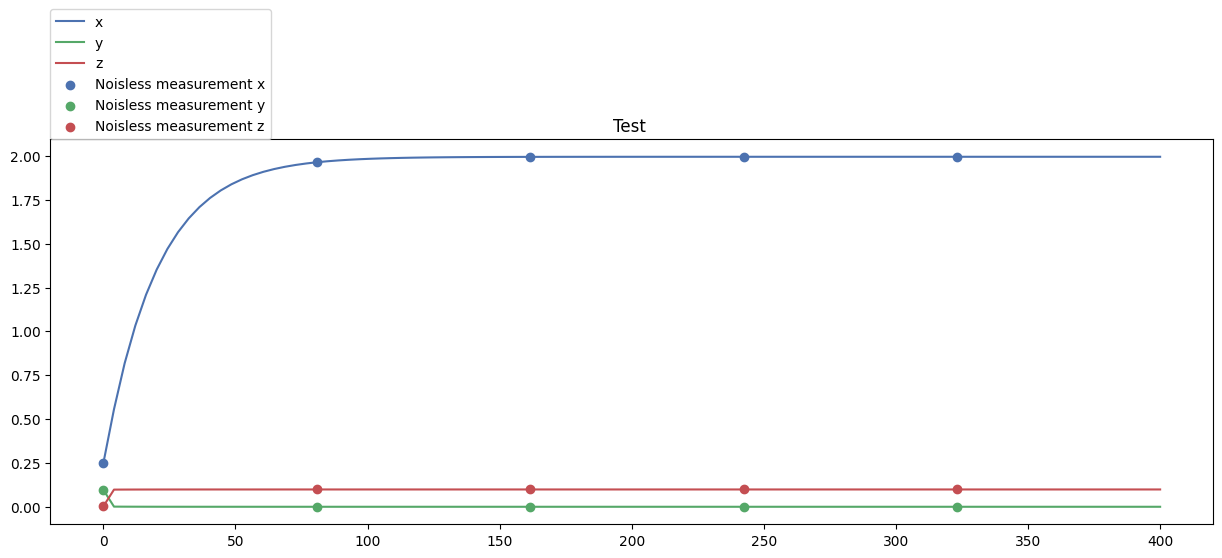

In [20]:
plt.style.use("seaborn-v0_8-deep")
fig, ax = plt.subplots(1, figsize=(15,5))
ax.plot(t_phys.detach().numpy(), x_phys, label='x')
ax.plot(t_phys.detach().numpy(), y_phys, label='y')
ax.plot(t_phys.detach().numpy(), z_phys, label='z')
ax.scatter(measurements_t.detach().numpy(), measurements[0,:], label='Noisless measurement x')
ax.scatter(measurements_t.detach().numpy(), measurements[1,:], label='Noisless measurement y')
ax.scatter(measurements_t.detach().numpy(), measurements[2,:], label='Noisless measurement z')
ax.legend(loc=(0,1))
ax.set_title('Test ')